In [83]:
!pip install pillow


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\deep\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [85]:
img = Image.open("image.png")

In [86]:
arr = np.array(img.convert("RGB"), dtype=float)
print(arr.shape)

(256, 256, 3)


In [87]:
U_list, S_list, VT_list = [], [], []
for i in range(arr.shape[2]):   
    u, s, vt = np.linalg.svd(arr[:, :, i], full_matrices=False)
    U_list.append(u)
    S_list.append(s)
    VT_list.append(vt)

In [88]:
def svd_reconstruct(U_list, S_list, VT_list, k):
    out = []
    for u, s, vt in zip(U_list, S_list, VT_list):
        approx = u[:, :k] @ np.diag(s[:k]) @ vt[:k, :]
        out.append(approx)
    return np.stack(out, axis=2)  

In [89]:
def psnr(original, approx):
    mse = np.mean((original - approx) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

In [90]:
target_psnr = 30
k = None

for i in range(1, min(arr.shape[:2])):  
    approx = svd_reconstruct(U_list, S_list, VT_list, i)
    if psnr(arr, approx) >= target_psnr:
        k = i
        break

print("Best k =", k)


Best k = 50


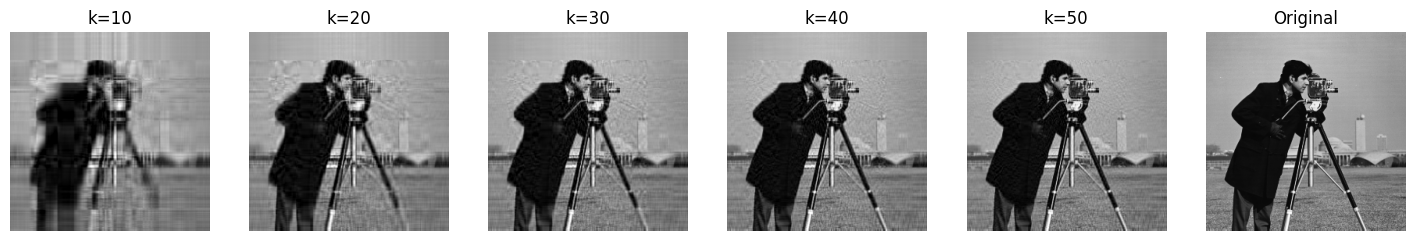

In [91]:
steps = [k//5 * i for i in range(1,6)]  

plt.figure(figsize=(18,6))

for idx, kval in enumerate(steps, 1):
    app = svd_reconstruct(U_list, S_list, VT_list, kval)
    app_img = np.clip(app, 0, 255).astype(int)

    plt.subplot(1, 6, idx)
    plt.imshow(app_img)
    plt.title(f"k={kval}")
    plt.axis("off")

plt.subplot(1, 6, 6)
plt.imshow(Image.open("image.png"))
plt.title(f"Original")
plt.axis("off")

plt.show()


In [93]:
orig = arr.shape[0] * arr.shape[1] * arr.shape[2]
comp = sum([U_list[i][:, :k].size + S_list[i][:k].size + VT_list[i][:k, :].size for i in range(3)])
ratio = orig / comp
print(f"CR: {ratio:.2f}")

rec = svd_reconstruct(U_list, S_list, VT_list, k)
rec_img = np.clip(rec, 0, 255).astype(np.uint8)
psnr_val = psnr(arr, rec)
print(f"PSNR: {psnr_val:.2f} dB")


CR: 2.56
PSNR: 30.11 dB
